# Bank Marketing Classification-LightGBM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, validation_curve

### Import Data

In [2]:
train_org = pd.read_csv("/kaggle/input/bank-marketing-dataset-full/bank-full.csv", sep=';')
train_org['y'] = train_org['y'].map({'yes': 1, 'no': 0})

######

train_df = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")
train_df = train_df.drop(["id"], axis=1)
train_df = pd.concat([train_df, train_org], axis=0).copy()
sample_submission.head()

,id,y
0,750000,0.5
1,750001,0.5
2,750002,0.5
3,750003,0.5
4,750004,0.5


In [3]:
print(train_df.head())
print(test_df.head())

   age          job  marital  education default  balance housing loan  \
0   42   technician  married  secondary      no        7      no   no   
1   38  blue-collar  married  secondary      no      514      no   no   
2   36  blue-collar  married  secondary      no      602     yes   no   
3   27      student   single  secondary      no       34     yes   no   
4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1  
       id  age            job  marital  education default  balance housing  \
0  750000   32    blue-collar  married 

In [4]:
train_df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000
mean,40.926953,1213.061980,16.099540,256.339096,2.587630,23.423889,0.314566,0.120442
std,10.129098,2848.603881,8.255231,271.723766,2.741838,78.901465,1.410369,0.325478
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,624.000000,17.000000,135.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,347.500000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [5]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


### Missing data

In [6]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


In [7]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 795211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        795211 non-null  int64 
 1   job        795211 non-null  object
 2   marital    795211 non-null  object
 3   education  795211 non-null  object
 4   default    795211 non-null  object
 5   balance    795211 non-null  int64 
 6   housing    795211 non-null  object
 7   loan       795211 non-null  object
 8   contact    795211 non-null  object
 9   day        795211 non-null  int64 
 10  month      795211 non-null  object
 11  duration   795211 non-null  int64 
 12  campaign   795211 non-null  int64 
 13  pdays      795211 non-null  int64 
 14  previous   795211 non-null  int64 
 15  poutcome   795211 non-null  object
 16  y          795211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 109.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999


### Categorical Variable Values

In [8]:
object_cols = train_df.select_dtypes(include="object").columns

for col_name in object_cols:
   print(f"{col_name} \n ***Train_df***-> {train_df[col_name].value_counts()} \n\n ***Test_df*** -> {test_df[col_name].value_counts()} \n\n")

job 
 ***Train_df***-> job
management       184999
blue-collar      180230
technician       145704
admin.            86663
services          68363
retired           37449
self-employed     20599
entrepreneur      19205
unemployed        18937
housemaid         17152
student           12705
unknown            3205
Name: count, dtype: int64 

 ***Test_df*** -> job
management       58636
blue-collar      56970
technician       45936
admin.           27009
services         21312
retired          11611
self-employed     6424
unemployed        6013
entrepreneur      5955
housemaid         5245
student           3867
unknown           1022
Name: count, dtype: int64 


marital 
 ***Train_df***-> marital
married     507973
single      207624
divorced     79614
Name: count, dtype: int64 

 ***Test_df*** -> marital
married     160412
single       64717
divorced     24871
Name: count, dtype: int64 


education 
 ***Train_df***-> education
secondary    424885
tertiary     240809
primary      106361

### Distribution of Target Variable

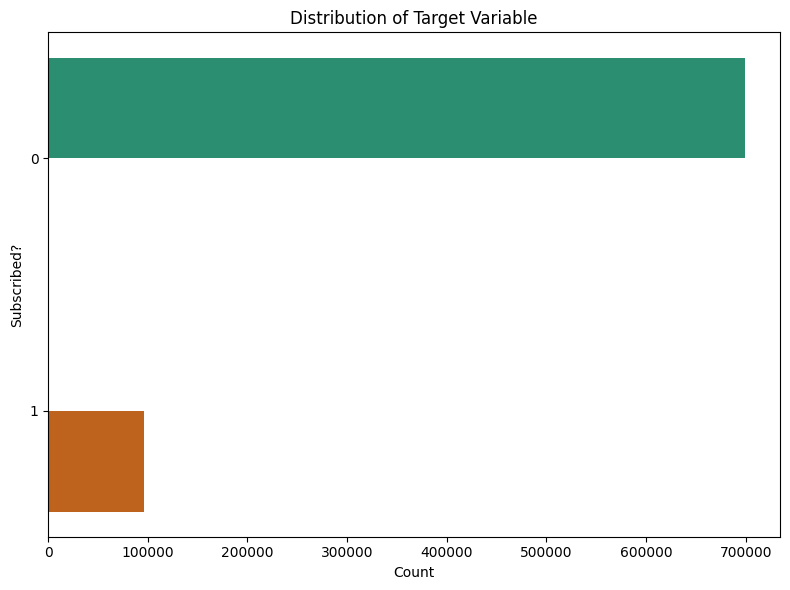

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='y', data=train_df, hue = 'y', palette='Dark2')
plt.title('Distribution of Target Variable')
plt.ylabel('Subscribed?')
plt.xlabel('Count')
plt.legend().remove()
plt.tight_layout()
plt.show()

### Correlation Matrix

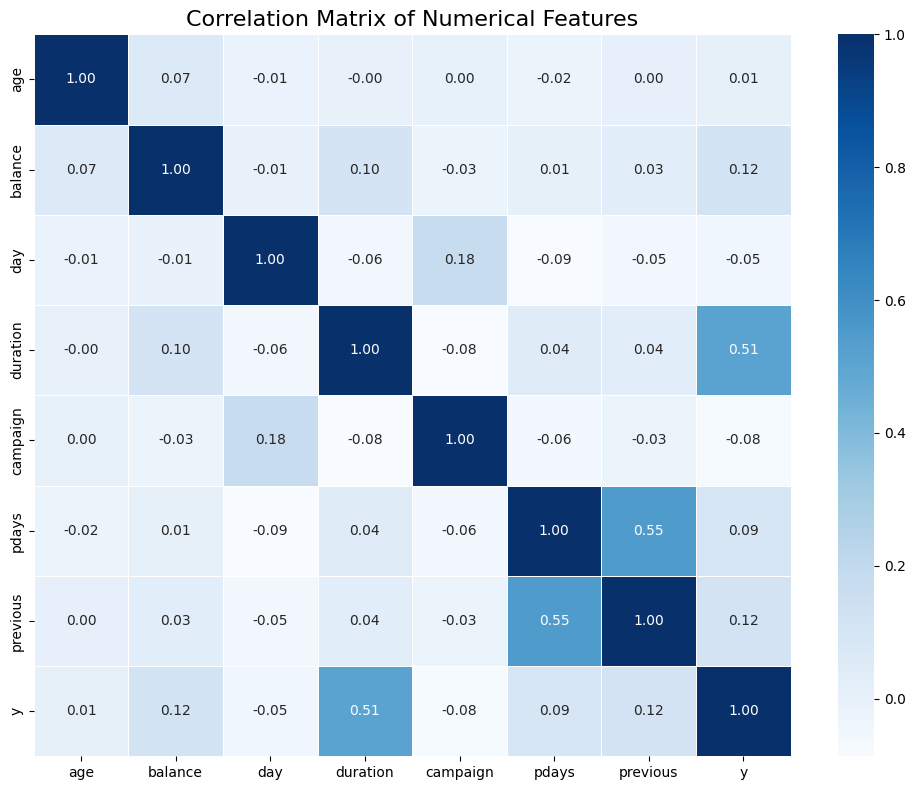

In [10]:
corr_features = [
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "y",
]
correlation_matrix = train_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

### Numerical Features vs. Target - Violin plot

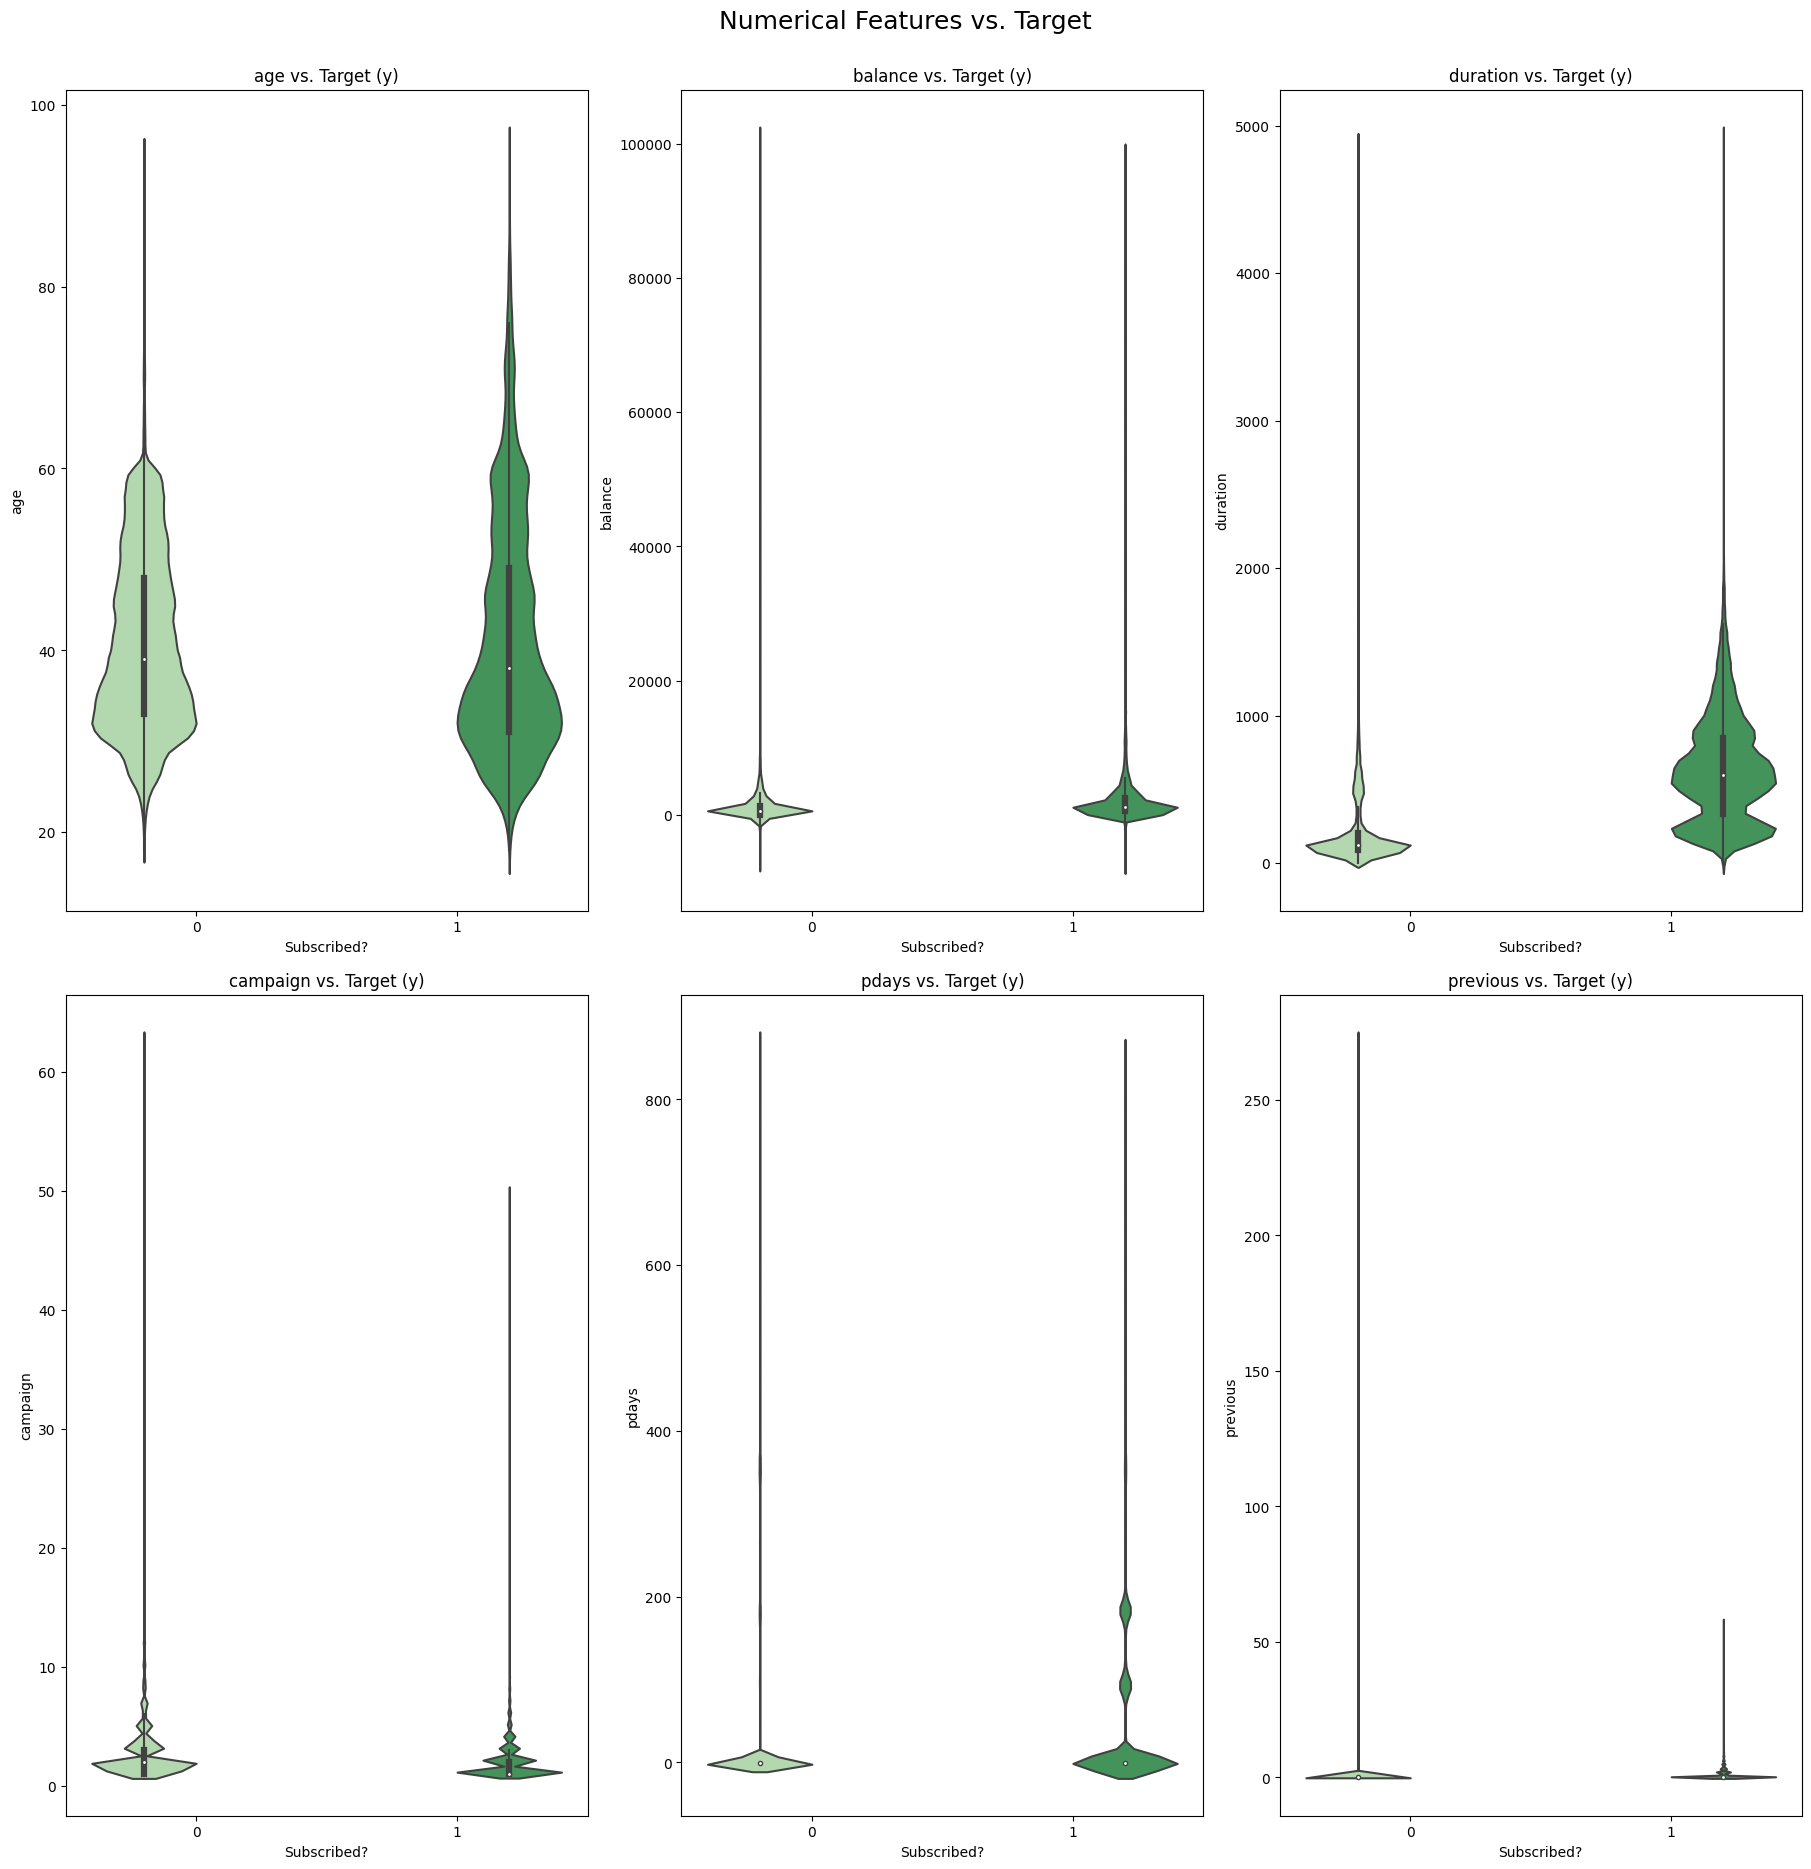

In [11]:
num_feat_violin = ["age", "balance", "duration", "campaign", "pdays", "previous"]

fig, axes = plt.subplots(
    2, 3, figsize=(18, 3 * 6), constrained_layout=True
)
axes = axes.flatten()

for i, feature in enumerate(num_feat_violin):
    sns.violinplot(
        x="y", y=feature, data=train_df, hue="y", ax=axes[i], palette="Greens"
    )
    axes[i].set_title(f"{feature} vs. Target (y)")
    axes[i].set_xlabel("Subscribed?")
    axes[i].set_ylabel(feature)
    axes[i].legend().remove()

fig.suptitle("Numerical Features vs. Target", fontsize=18, y=1.03)
plt.show()

### FE

In [12]:
month_map = {'jan': 1,
             'feb': 2,
             'mar': 3,
             'apr': 4,
             'may': 5,
             'jun': 6,
             'jul': 7,
             'aug': 8,
             'sep': 9,
             'oct': 10,
             'nov': 11,
             'dec': 12
        }


train_df['month_num'] = train_df['month'].map(month_map)
test_df['month_num'] = test_df['month'].map(month_map)



def new_feats(df):
    df = df.copy()
    df['balance_posi'] = (df['balance'] > 0).astype(int)
    df['has_previous'] = (df['previous'] > 0).astype(int)
    df['long_duration'] = (df['duration'] >= 360).astype(int)
    df['campaign_multi'] = (df['campaign'] >= 2).astype(int)
    df['is_first_contact'] = (df['campaign'] == 1).astype(int)
    df['high_campaign'] = (df['campaign'] >= 3).astype(int)
    df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
    df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 97], 
                             labels=['young', 'adult', 'middle', 'senior', 'elderly']).astype("object")
    df['log_duration'] = np.log1p(df['duration'])
    df['sqrt_duration'] = np.sqrt(df['duration'])
    df['log_campaign']=np.log1p(df['campaign'])
    df['sqrt_age'] = df['age'] ** 2
    df['cubed_age'] = df['age'] ** 3
    df['log_age'] = np.log1p(df['age'])
    return df


train_df = new_feats(train_df)
train_df= train_df.drop(columns=['month', 'month_num', 'duration'])
test_df = new_feats(test_df)
test_df= test_df.drop(columns=['month', 'month_num', "duration"])

object_cols = train_df.select_dtypes(include="object").columns

In [13]:
train_df.describe()

,age,balance,day,campaign,pdays,previous,y,balance_posi,has_previous,long_duration,...,is_first_contact,high_campaign,month_sin,month_cos,log_duration,sqrt_duration,log_campaign,sqrt_age,cubed_age,log_age
count,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,...,795211.000000,795211.000000,7.952110e+05,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000,795211.000000
mean,40.926953,1213.061980,16.099540,2.587630,23.423889,0.314566,0.120442,0.742101,0.107929,0.247787,...,0.404955,0.315447,-2.095554e-02,-0.496179,5.071070,14.259753,1.129011,1777.613958,81766.406087,3.707472
std,10.129098,2848.603881,8.255231,2.741838,78.901465,1.410369,0.325478,0.437478,0.310290,0.431728,...,0.490884,0.464694,6.127892e-01,0.614701,1.025905,7.280015,0.485408,899.378160,64220.770406,0.238021
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000e+00,-1.000000,0.000000,0.000000,0.693147,324.000000,5832.000000,2.944439
25%,33.000000,0.000000,9.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-5.000000e-01,-0.866025,4.521789,9.539392,0.693147,1089.000000,35937.000000,3.526361
50%,39.000000,624.000000,17.000000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.224647e-16,-0.866025,4.912655,11.618950,1.098612,1521.000000,59319.000000,3.688879
75%,48.000000,1390.000000,21.000000,3.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,5.000000e-01,-0.500000,5.853637,18.641347,1.386294,2304.000000,110592.000000,3.891820
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000e+00,1.000000,8.500861,70.128454,4.158883,9025.000000,857375.000000,4.564348


In [14]:
test_df.describe()

,id,age,balance,day,campaign,pdays,previous,balance_posi,has_previous,long_duration,...,is_first_contact,high_campaign,month_sin,month_cos,log_duration,sqrt_duration,log_campaign,sqrt_age,cubed_age,log_age
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.00000,250000.000000,...,250000.000000,250000.000000,2.500000e+05,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,2.573548,22.280028,0.303728,0.736320,0.10356,0.249132,...,0.406756,0.313092,-2.278417e-02,-0.496392,5.061341,14.212949,1.126458,1777.094316,81665.789948,3.707865
std,72168.927986,10.081613,2741.520699,8.258509,2.709661,76.915879,1.384574,0.440629,0.30469,0.432511,...,0.491230,0.463752,6.128257e-01,0.614429,1.032576,7.303050,0.483530,894.650932,63823.289270,0.236921
min,750000.000000,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,-1.000000e+00,-1.000000,1.386294,1.732051,0.693147,324.000000,5832.000000,2.944439
25%,812499.750000,33.000000,0.000000,9.000000,1.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,-5.000000e-01,-0.866025,4.521789,9.539392,0.693147,1089.000000,35937.000000,3.526361
50%,874999.500000,39.000000,631.000000,17.000000,2.000000,-1.000000,0.000000,1.000000,0.00000,0.000000,...,0.000000,0.000000,1.224647e-16,-0.866025,4.897840,11.532563,1.098612,1521.000000,59319.000000,3.688879
75%,937499.250000,48.000000,1389.000000,21.000000,3.000000,-1.000000,0.000000,1.000000,0.00000,0.000000,...,1.000000,1.000000,5.000000e-01,-0.500000,5.869297,18.788294,1.386294,2304.000000,110592.000000,3.891820
max,999999.000000,95.000000,98517.000000,31.000000,58.000000,871.000000,150.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000e+00,1.000000,8.500861,70.128454,4.077537,9025.000000,857375.000000,4.564348


### Split

In [15]:
X = train_df.drop(["y"], axis=1)
y = train_df["y"]
X_test = test_df.drop(["id"], axis=1)

### LabelEncoder

In [16]:
for col_name in object_cols:
    le = LabelEncoder()
    X[col_name] = le.fit_transform(X[col_name])
    X_test[col_name] = le.transform(X_test[col_name])

### CV | Predict

In [17]:
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
y_probs = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"-----------------")
    print(f"******{fold + 1}/{n_splits}*******")
    print(f"-----------------")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        n_estimators=25000,
        learning_rate=0.03,
        min_child_samples=9,
        subsample=0.8,
        colsample_bytree=0.5,
        num_leaves=100,
        max_depth=10,
        max_bin=4523,
        reg_alpha=0.79,
        reg_lambda=3,
    )
    
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_val, y_val)], 
        callbacks=[
            lgb.early_stopping(300),
            lgb.log_evaluation(period=50)
        ]
    )
    
    y_probs += model.predict_proba(X_test)[:, 1] / n_splits


-----------------
******1/10*******
-----------------
Training until validation scores don't improve for 300 rounds
[50]	valid_0's binary_logloss: 0.191638
[100]	valid_0's binary_logloss: 0.164288
[150]	valid_0's binary_logloss: 0.155399
[200]	valid_0's binary_logloss: 0.151569
[250]	valid_0's binary_logloss: 0.149243
[300]	valid_0's binary_logloss: 0.147498
[350]	valid_0's binary_logloss: 0.146027
[400]	valid_0's binary_logloss: 0.144725
[450]	valid_0's binary_logloss: 0.143711
[500]	valid_0's binary_logloss: 0.142902
[550]	valid_0's binary_logloss: 0.142179
[600]	valid_0's binary_logloss: 0.141615
[650]	valid_0's binary_logloss: 0.141036
[700]	valid_0's binary_logloss: 0.140646
[750]	valid_0's binary_logloss: 0.140127
[800]	valid_0's binary_logloss: 0.139669
[850]	valid_0's binary_logloss: 0.139291
[900]	valid_0's binary_logloss: 0.138948
[950]	valid_0's binary_logloss: 0.138617
[1000]	valid_0's binary_logloss: 0.138274
[1050]	valid_0's binary_logloss: 0.137986
[1100]	valid_0's binar

### Model Validation Curve

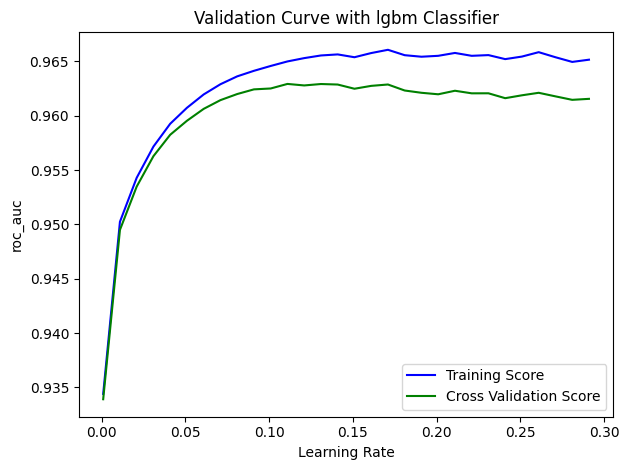

In [18]:
parameter_range = np.arange(0.001, 0.3, 0.01)
train_score, test_score = validation_curve(
    lgb.LGBMClassifier(
  ),
    X,
    y,
    param_name="learning_rate",
    param_range=parameter_range,
    cv=5,
    scoring="roc_auc",
)

mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

plt.title("Validation Curve with lgbm Classifier")
plt.xlabel("Learning Rate")
plt.ylabel("roc_auc")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

## Variable Importance

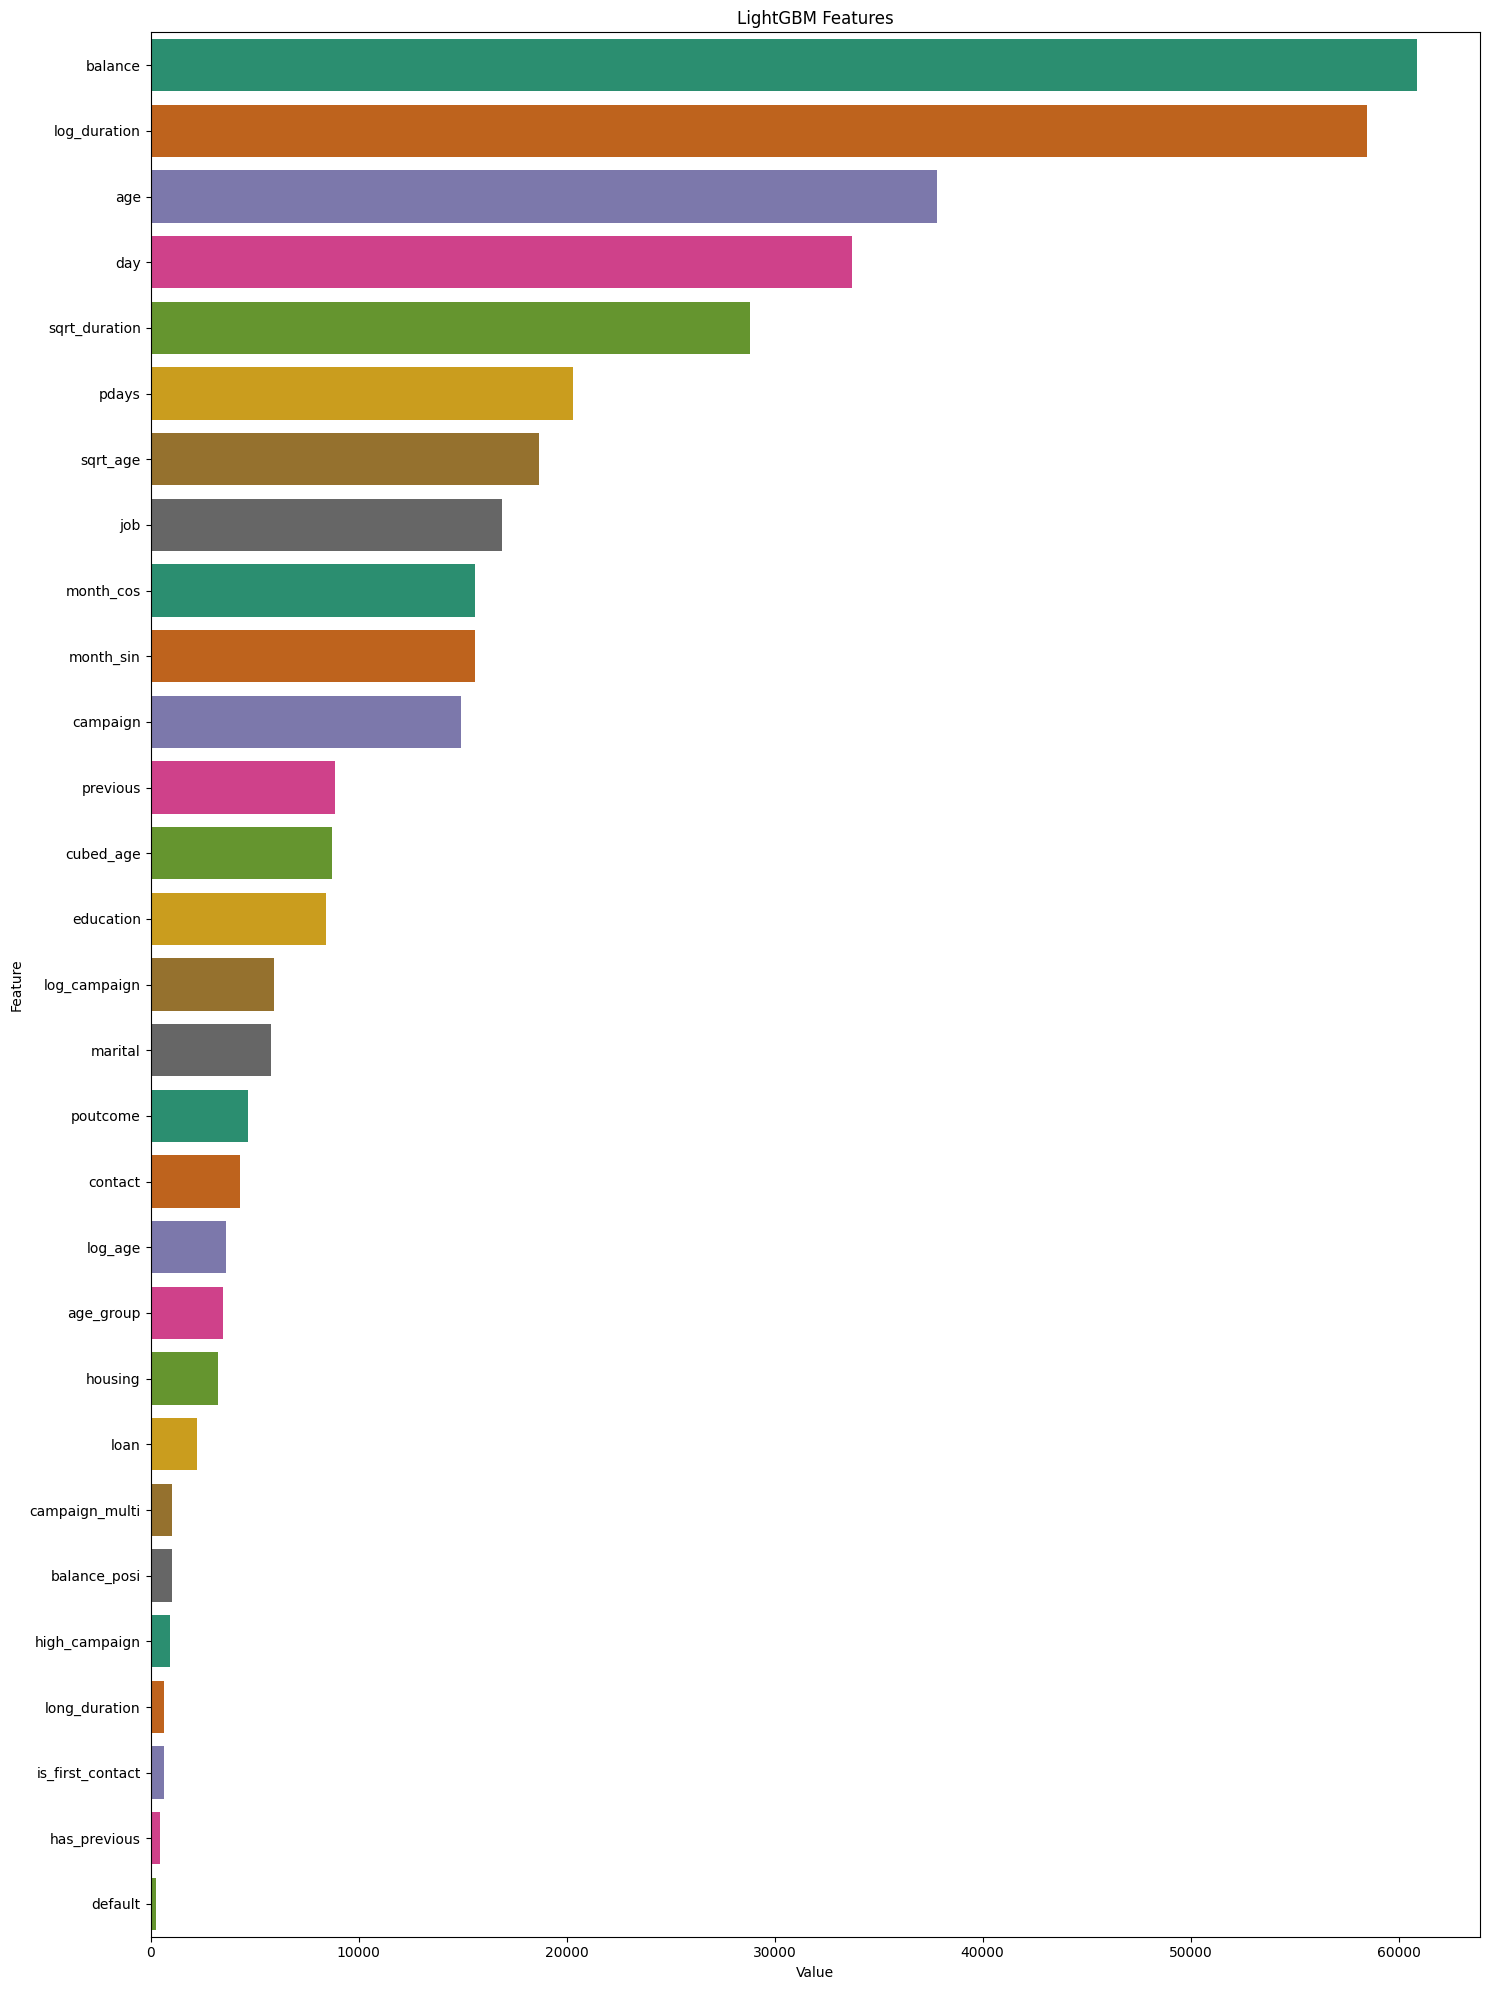

In [19]:

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 20))
sns.barplot(x="Value", y="Feature", palette = "Dark2", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

### Submission

In [20]:
submission = pd.DataFrame({"id": test_df["id"], "y": y_probs})
submission.to_csv("submission.csv", index=False)